In [1]:
import ast, glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from myutils import data_utils as du

In [2]:
fink_colors_list = ["#15284F", "#F5622E", "#D5D5D3", "#3C8DFF"]
fink_colors_dic = {"FINK":"#15284F", "ZTF":"#F5622E", "TNS":"#D5D5D3"}

In [3]:
mpl.rcParams["font.size"] = 16
mpl.rcParams["legend.fontsize"] = "medium"
mpl.rcParams["figure.titlesize"] = "large"
mpl.rcParams["lines.linewidth"] = 3

# Data

### TNS classifications within time-range of experiment

In [4]:
# read TNS labels and apply timeranges for this experiment
df_dic = {}
df_TNS_tmp = du.load_TNS_reformat('../classifications/tns_fink_20230817.parquet')
df_dic['TNS'] = du.apply_timerange_fink_fup(df_TNS_tmp, ndaysplus=9)
# two types are missing, they are non Ia so AL loop is ok
df_dic['TNS'].loc[df_dic['TNS']['ztf_names'] == "ZTF24aahsmkt", 'type'] = "II"
df_dic['TNS'].loc[df_dic['TNS']['ztf_names'] == "ZTF23abfpegt", 'type'] = "IIB"
df_dic['TNS'].loc[df_dic['TNS']['ztf_names'] == "ZTF24aakaiha", 'type'] = "TDE" # reclassified from Ia to TDE-He 7/6/24
df_dic['TNS'].loc[df_dic['TNS']['type']=='DE', 'type'] = "TDE"

# classified by ZTF
df_dic['ZTF'] = df_dic['TNS'][df_dic['TNS']['reporting_group']=='ZTF']

# FINK
tmp0 = pd.read_csv('../classifications/ALbot_with_classifications_curated_original.tsv', sep='\t')
tmp0 = pd.merge(tmp0, df_dic['TNS'][['ztf_names', 'type']], on='ztf_names', how='left')
# nonIa types missing, adding these tags
tmp = pd.read_csv('../classifications/ALbot_with_classifications_curated_original_nonIatypes.csv', sep=' ')
tmp = tmp.rename(columns={'type':'classtmp'}) 
df_merged = pd.merge(tmp0, tmp, on='ztf_names', how='left')
df_merged['type'] = df_merged.apply(lambda row: row.classtmp if row.type is np.nan else row.type, axis=1)
df_merged['type'] = df_merged.apply(lambda row: row.Classification if row.type is np.nan else row.type, axis=1)
df_dic['FINK'] = df_merged


BEWARE! Not all detected by ZTF will enter in our AL loop (with valid features), so we need to subsample

In [5]:
# load metrics
metrics_dic = {}
metrics_dic["FINK"] = pd.read_csv('../dump/data_fink/metrics.csv')
metrics_dic["ZTF"] = pd.read_csv('../dump/data_ZTF/metrics.csv')
metrics_dic["TNS"] = pd.read_csv('../dump/data_allTNS/metrics.csv')


In [6]:
used_names_dic = {}
for k in metrics_dic.keys():
    tmp= metrics_dic[k]['query_objectIds'].apply(ast.literal_eval)
    # Flatten the column to a list
    used_names_dic[k] = tmp.explode().tolist()


In [7]:
# filter to those used in AL loop
for k in df_dic.keys():
    print(f"{k} before filtering: {df_dic[k].shape[0]}")
    df_dic[k] = df_dic[k][df_dic[k]['ztf_names'].isin(used_names_dic[k])]
    print(f"{k} after filtering: {df_dic[k].shape[0]}")


TNS before filtering: 622
TNS after filtering: 302
ZTF before filtering: 256
ZTF after filtering: 135
FINK before filtering: 96
FINK after filtering: 92


In [8]:
print(df_dic['FINK'].groupby('type').size().to_latex(index=True))

\begin{tabular}{lr}
\toprule
 & 0 \\
type &  \\
\midrule
II & 9 \\
IIb & 1 \\
Ia & 62 \\
Ia-91T-like & 2 \\
Ia-pec & 2 \\
Iax[02cx-like] & 1 \\
Ibn & 2 \\
Ic-BL & 1 \\
SLSN & 1 \\
featureless & 2 \\
microlensing & 2 \\
other & 5 \\
star & 2 \\
\bottomrule
\end{tabular}



### Types in AL loop

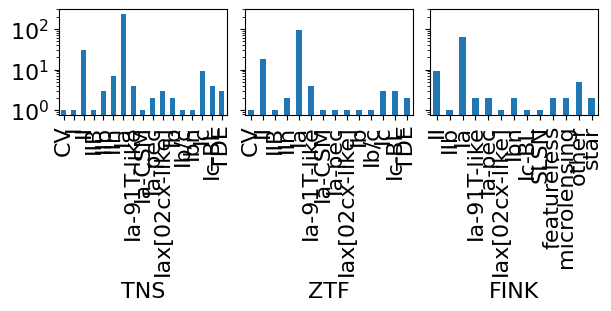

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots(sharex=False, sharey=True)
df_dic['TNS'].groupby('type').size().plot(kind='bar', ax= axs[0],xlabel='TNS')
df_dic['ZTF'].groupby('type').size().plot(kind='bar', ax= axs[1],xlabel='ZTF')
df_dic['FINK'].groupby('type').size().plot(kind='bar', ax= axs[2],xlabel='FINK')
plt.yscale('log')


Family of types may be more indicative

In [10]:
all_types = np.concat([df_dic[k]['type'].unique() for k in df_dic.keys()])
set(all_types)

{'CV',
 'I',
 'II',
 'IIB',
 'IIb',
 'IIn',
 'Ia',
 'Ia-91T-like',
 'Ia-CSM',
 'Ia-pec',
 'Iax[02cx-like]',
 'Ib',
 'Ib/c',
 'Ibn',
 'Ic',
 'Ic-BL',
 'SLSN',
 'TDE',
 'featureless',
 'microlensing',
 'other',
 'star'}

In [11]:
family_types = {
    'star':['CV','star'],
    'SNIbc':['I','Ib', 'Ib/c', 'Ibn', 'Ic', 'Ic-BL'],
    'SNIa-like':['Ia', 'Ia-91T-like', 'Ia-CSM', 'Ia-pec', 'Iax[02cx-like]'],
    'SNII':['II', 'IIB', 'IIb', 'IIn'],
    'SLSN':['SLSN'],
    'TDE':['TDE'],
    'other':['featureless', 'microlensing', 'other']}

def get_family(x, family_types):
    for k in family_types.keys():
        if x in family_types[k]:
            return k
    return 'unknown'

for k in df_dic.keys():
    df_dic[k]['type families'] = df_dic[k]['type'].apply(lambda x: get_family(x, family_types))

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_85055/1869745522.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dic[k]['type families'] = df_dic[k]['type'].apply(lambda x: get_family(x, family_types))


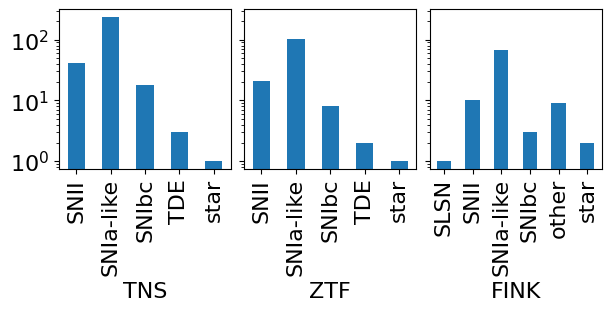

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(6, 3))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots(sharex=False, sharey=True)
df_dic['TNS'].groupby('type families').size().plot(kind='bar', ax= axs[0],xlabel='TNS')
df_dic['ZTF'].groupby('type families').size().plot(kind='bar', ax= axs[1],xlabel='ZTF')
df_dic['FINK'].groupby('type families').size().plot(kind='bar', ax= axs[2],xlabel='FINK')
plt.yscale('log')


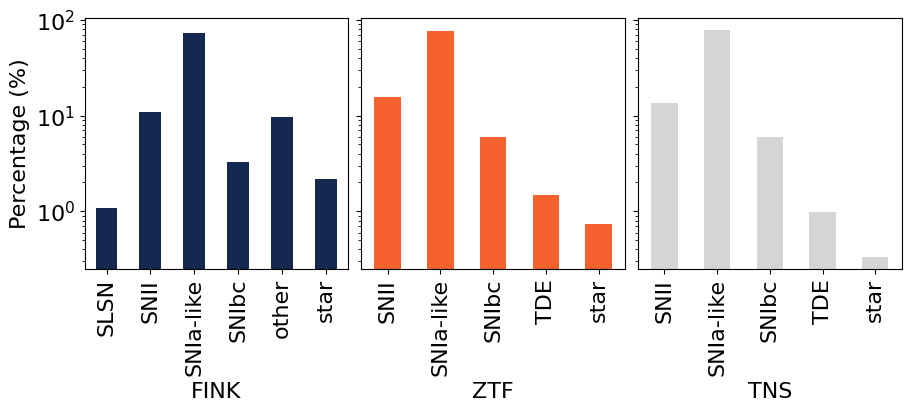

In [13]:
# Create figure and subplots with gridspec
fig = plt.figure(constrained_layout=True, figsize=(9, 4))
gs = fig.add_gridspec(1, 3)
axs = gs.subplots(sharex=False, sharey=True)

# Function to calculate percentages and plot
def plot_percentage(df, ax, label):
    # Calculate percentages
    counts = df.groupby('type families').size()
    percentages = (counts / counts.sum()) * 100
    # Plot bar chart
    percentages.plot(kind='bar', ax=ax, xlabel=label,color=fink_colors_dic[label])
    ax.set_ylabel('Percentage (%)')

# Plot each DataFrame with percentages on a separate subplot
plot_percentage(df_dic['TNS'], axs[2], 'TNS')
plot_percentage(df_dic['ZTF'], axs[1], 'ZTF')
plot_percentage(df_dic['FINK'], axs[0], 'FINK')

# Apply log scale to the y-axis for each subplot (if needed for percentage)
for ax in axs:
    ax.set_yscale('log')

plt.savefig('../plots/ALloop_types.png', bbox_inches='tight')
# Display the plot
plt.show()




In [14]:
df_dic['TNS'][df_dic['TNS']['type families']=='unknown']

,ztf_names,type AL,discoveryjd,type,reporting_group,fup requested,fup requested (str),label acquired,type families


### Follow-up magnitude in AL loop
instead of querying Fink as in AL loop, we can use the queried data files

In [28]:
df_mags_dic={}
path_dic = {'FINK':'../dump/data_fink/', 'ZTF':'../dump/data_ZTF/', 'TNS':'../dump/data_allTNS/'}
for k in df_dic.keys():
    list_tmp = []
    for l, fil in enumerate(np.sort(glob.glob(f'{path_dic[k]}/*/*/queries/alert_data.csv'))):
        tmp = pd.read_csv(fil)
        tmp['mag_list'] =tmp['cmagpsf'].apply(lambda x: list(map(float, x.strip('[]').split())))
        tmp['mag_last_value'] = tmp['mag_list'].apply(lambda x: x[-1])
        tmp['photometric measurements'] = tmp['mag_list'].apply(len)
        tmp['loop']= np.ones(len(tmp))*l
        list_tmp.append(tmp[['objectId','mag_last_value','photometric measurements','loop']])
    df_mags_dic[k] = pd.concat(list_tmp)

TNS 19.470484499999998 \pm 0.7189964653409605
ZTF 19.463097 \pm 0.6479567984863928
FINK 19.5310075 \pm 0.6799351257597739


Text(0, 0.5, '# light-curves')

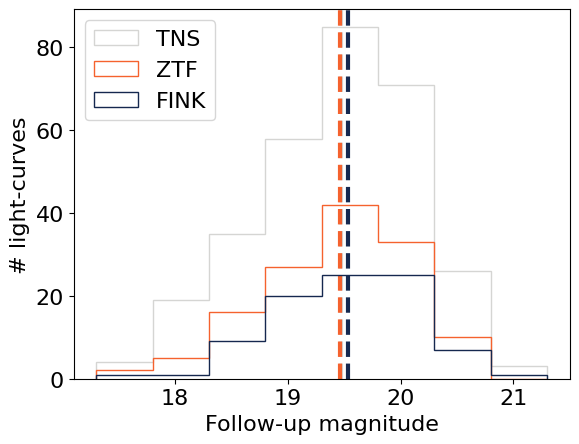

In [43]:
mybins = np.arange(17.3,21.5,0.5)
for k in df_mags_dic.keys():
    plt.hist(df_mags_dic[k]['mag_last_value'],label=k, bins=mybins,histtype='step',color=fink_colors_dic[k])
    plt.axvline(df_mags_dic[k]['mag_last_value'].median(), color=fink_colors_dic[k], linestyle='--')
    print(f"{k} {df_mags_dic[k]['mag_last_value'].median()} \pm {df_mags_dic[k]['mag_last_value'].std()}")
plt.legend()
plt.xlabel('Follow-up magnitude')
plt.ylabel('# light-curves')



#### Does this evolve with loop?



19.724445 \pm 0.8079853362659717
19.537792 \pm 0.5598532914795652
19.4426935 \pm 0.589247035956103


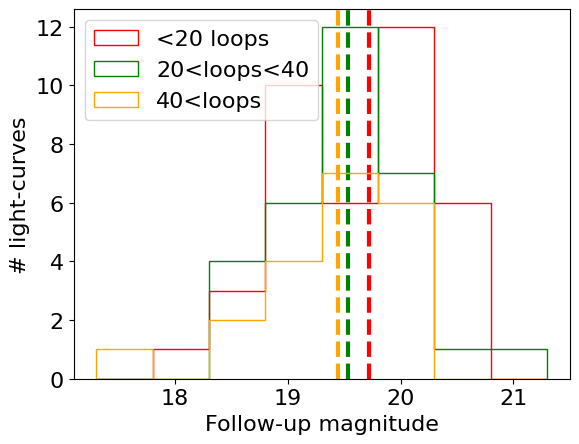

In [37]:
mybins = np.arange(17.3,21.5,0.5)

sel1 = df_mags_dic['FINK'][df_mags_dic['FINK']['loop'] <20]
sel2 = df_mags_dic['FINK'][(df_mags_dic['FINK']['loop'] >=20) & (df_mags_dic['FINK']['loop'] <40)]
sel3= df_mags_dic['FINK'][(df_mags_dic['FINK']['loop'] >=40)]

plt.hist(sel1['mag_last_value'],label='<20 loops', bins=mybins,histtype='step',color='red')
plt.axvline(sel1['mag_last_value'].median(), color='red', linestyle='--')
print(f"{sel1['mag_last_value'].median()} \pm {sel1['mag_last_value'].std()}")


plt.hist(sel2['mag_last_value'],label='20<loops<40', bins=mybins,histtype='step',color='green')
plt.axvline(sel2['mag_last_value'].median(), color='green', linestyle='--')
print(f"{sel2['mag_last_value'].median()} \pm {sel2['mag_last_value'].std()}")

plt.hist(sel3['mag_last_value'],label='40<loops', bins=mybins,histtype='step',color='orange')
plt.axvline(sel3['mag_last_value'].median(), color='orange', linestyle='--')
print(f"{sel3['mag_last_value'].median()} \pm {sel3['mag_last_value'].std()}")

plt.xlabel('Follow-up magnitude')
plt.ylabel('# light-curves')
plt.legend()



# Followup by type and magnitude?

Text(0, 0.5, '# light-curves')

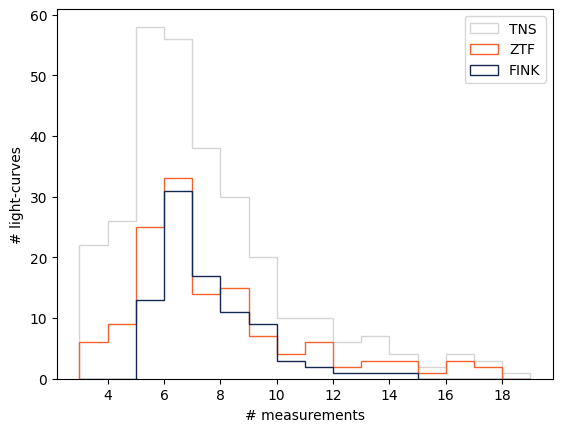

In [17]:
mybins = np.arange(3,20,1)
for k in df_mags_dic.keys():
    plt.hist(df_mags_dic[k]['photometric measurements'],label=k, bins=mybins,histtype='step',color=fink_colors_dic[k])
plt.legend()
plt.xlabel('# measurements')
plt.ylabel('# light-curves')

# List of fup targets for DLR xmatch

In [13]:
all_fup_names = []
for k in used_names_dic.keys():
    all_fup_names += used_names_dic[k]

In [43]:
import requests, io
list_df = []
for objid in all_fup_names:
    r = requests.post(
        "https://fink-portal.org/api/v1/objects",
        json={
            "objectId": objid,
            "output-format": "json",
            "columns": "i:objectId,i:ra,i:dec",
        },
    )
    pdf_tmp = pd.read_json(io.BytesIO(r.content))
    list_df.append(pdf_tmp.iloc[:1])
pdf_dlr = pd.concat(list_df)

In [45]:
pdf_dlr.to_csv('../dump/to_crossmatch_host.csv',index=False)